# Introduction
The Housing Prices data seemed interesting to me because of the large number of features, so in this work I focused on data cleaning and feature engineering. Then i tested different feature sets on several models.

I would like to know your opinion on how I can improve my future works. Enjoy reading!

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
train_df = train.copy()

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Data cleaning
## Missing values

Explore columns that have missing values.

In [2]:
missing = train_df.isnull().sum()[train_df.isnull().sum() > 0]
missing_df = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing / len(train_df)}).sort_values(by = 'NaN_percentage', ascending = False)
missing_df

,NaN_count,NaN_percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Drop **Id** and columns that are missing too many values.

In [3]:
train_df = train_df.drop(columns = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])

Fill in the missing values of the remaining numerical columns.

In [4]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean())
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean())
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].mode()[0])

Fill in the missing values of the remaining categorical columns.

In [5]:
missing_useless = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
missing_df = missing_df.drop(missing_useless)

for feature in missing_df.index:
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])

## Outliers
Separate numerical and categorical features.

In [6]:
y = train_df['SalePrice'].copy()
train_df = train_df.drop(columns = 'SalePrice')

num_cols = [i for i in train_df.columns if train_df[i].dtype in ['int', 'float']]
cat_cols = [i for i in train_df.columns if train_df[i].dtype == 'object']

print('Number of numerical columns:', len(num_cols))
print('Number of categorical columns:', len(cat_cols))

Number of numerical columns: 36
Number of categorical columns: 38


Plot the numerical features.

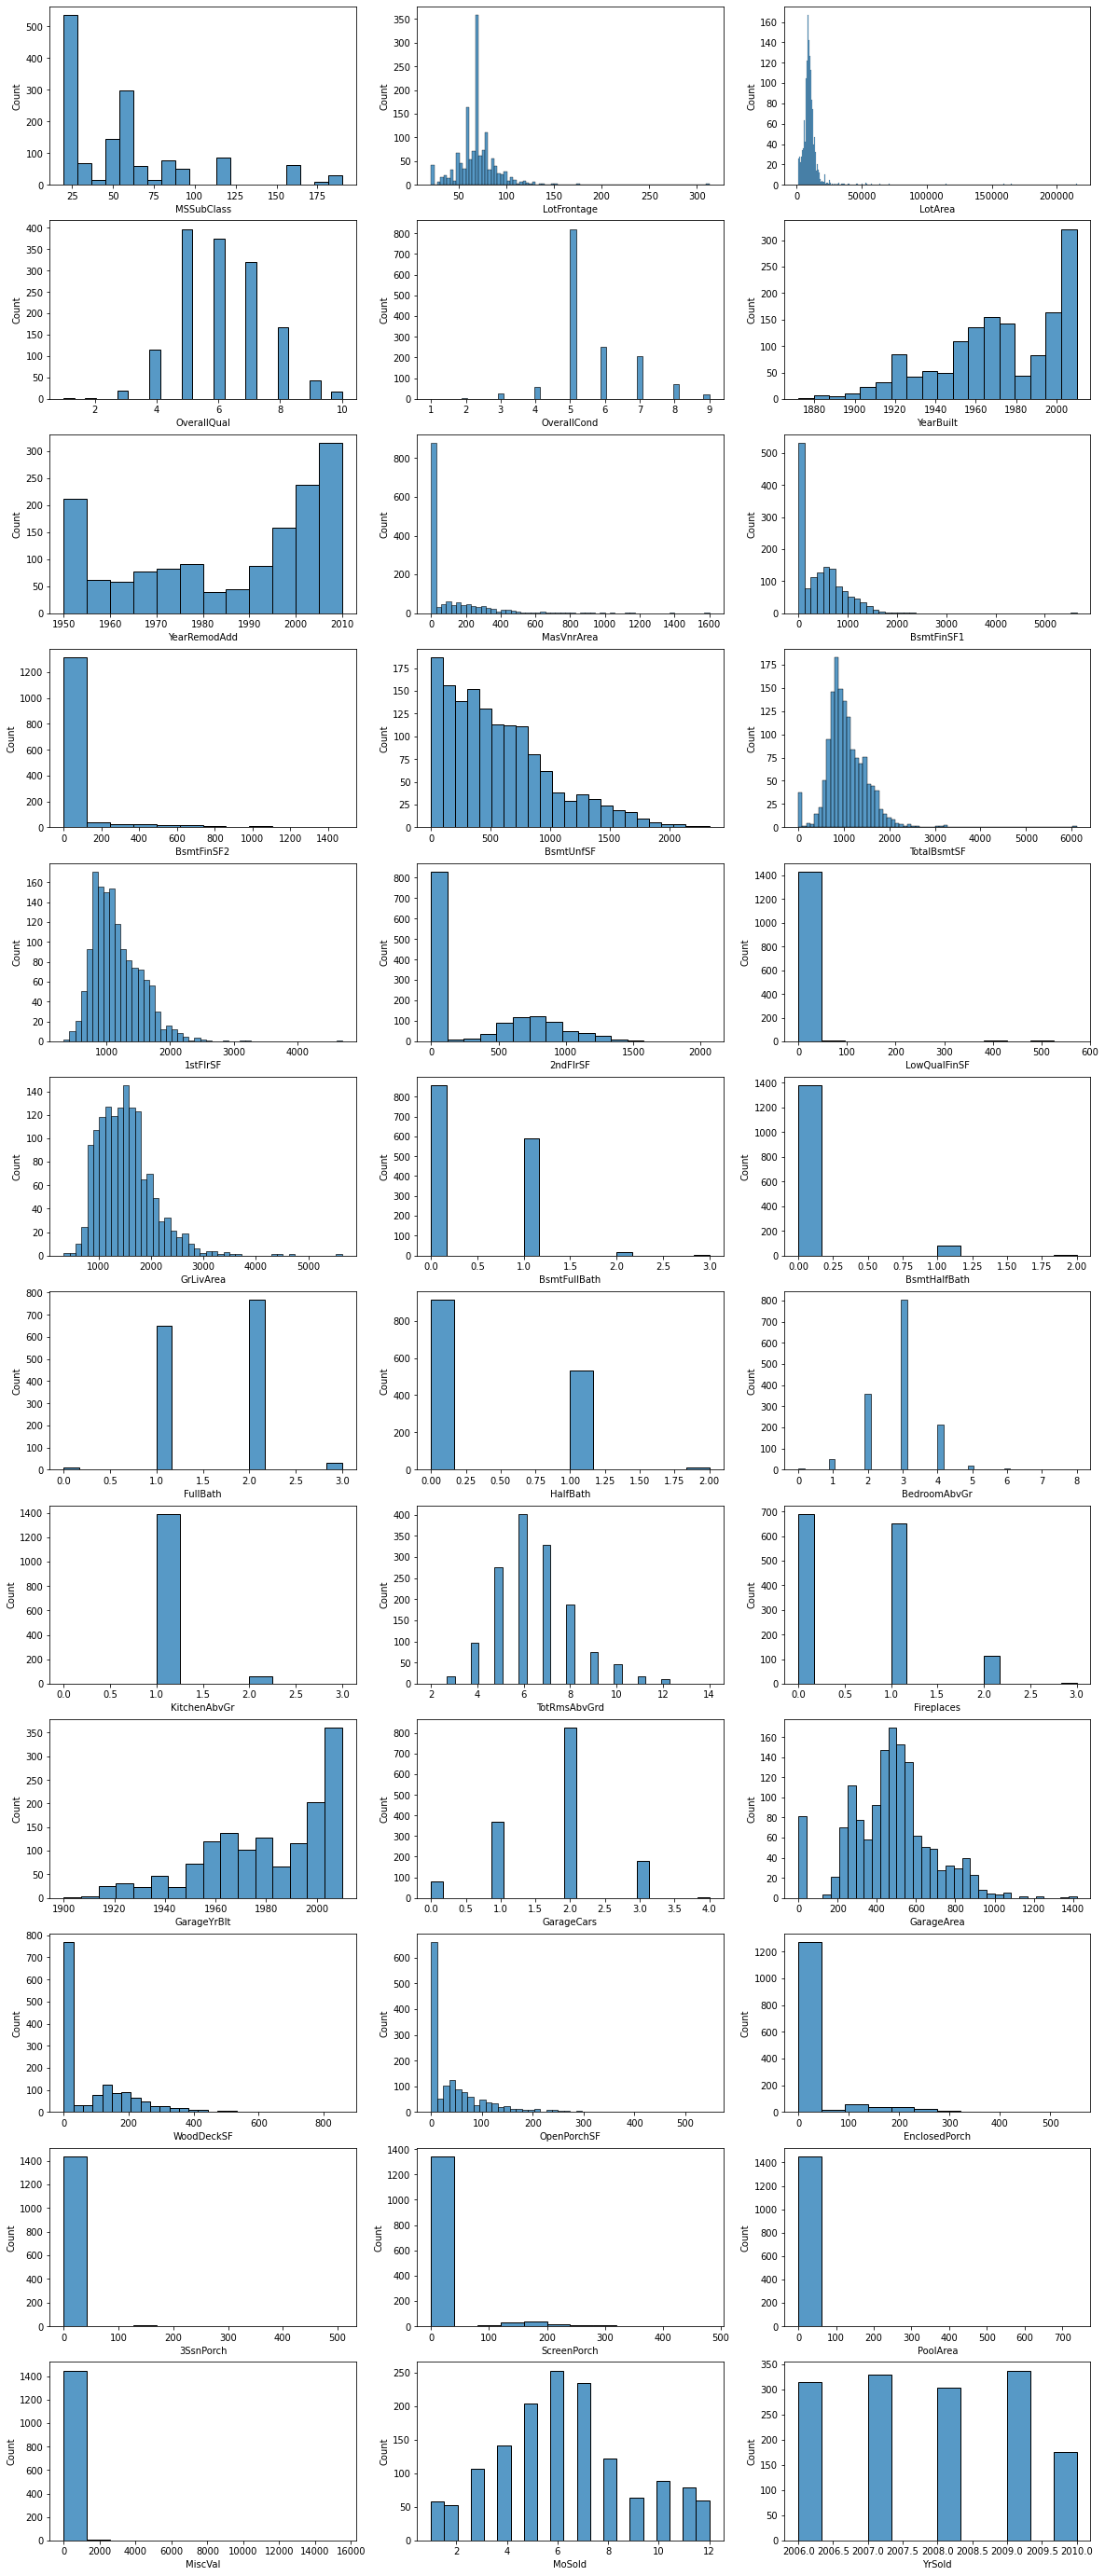

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
 
fig, ax = plt.subplots(12, 3, figsize = (20, 50))
c = 0
for i in range(12):
    for j in range(3):
        if c == 36:
            break
        sns.histplot(x = train_df[num_cols[c]], ax = ax[i, j])
        c += 1
plt.show()

Explore the features.

In [8]:
cls_outlier = [i for i in num_cols if train_df[i].quantile(0.99) != 0]
vls_outlier = [train_df[i].max() / train_df[i].quantile(0.99) for i in cls_outlier]
unq_outlier = [train_df[i].nunique() for i in cls_outlier]
has_outlier = [train_df[i].max() - train_df[i].quantile(0.75) > 1.5 * (train_df[i].quantile(0.75) - train_df[i].quantile(0.25)) for i in cls_outlier]

df_outlier = pd.DataFrame({'Max/0.99': vls_outlier, 'N_unique': unq_outlier, 'Has_outlier': has_outlier}, index = cls_outlier)
df_outlier.sort_values(by = 'Max/0.99', ascending = False)

,Max/0.99,N_unique,Has_outlier
MiscVal,22.142857,21,True
LotArea,5.729532,1073,True
BsmtFinSF1,3.589395,637,True
3SsnPorch,3.023810,20,True
TotalBsmtSF,2.835201,721,True
LotFrontage,2.277855,111,True
EnclosedPorch,2.114537,120,True
1stFlrSF,2.114028,753,True
MasVnrArea,2.022040,328,True
HalfBath,2.000000,3,False


Change the values of features that have outliers.

In [9]:
outlier_cols = [i for i in df_outlier.index if df_outlier.loc[i, 'N_unique'] > 350 and df_outlier.loc[i, 'Has_outlier']]

for col in outlier_cols:
    up_ext = train_df[col].quantile(0.75) + 1.5 * (train_df[col].quantile(0.75) - train_df[col].quantile(0.25))
    train_df[col] *= up_ext / train_df[col].max()

## Uninformative features
Plot the number of unique values for each categorical feature.

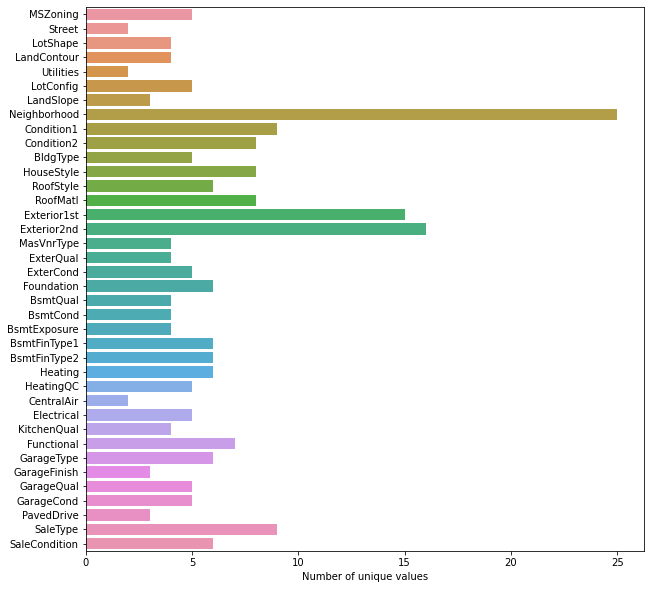

In [10]:
plt.figure(figsize = (10, 10))
sns.barplot(x = train_df[cat_cols].nunique(), y = cat_cols)
plt.xlabel('Number of unique values')
plt.show()

Find out which features consist mainly of the same value.

In [11]:
cat_frequency = pd.DataFrame(columns = ['Most_frequent_%', 'Second_frequent_%'], index = cat_cols)

for i, col in enumerate(cat_cols):
    count = train_df[col].value_counts()
    count_percent = count / len(train_df) * 100
    cat_frequency.iloc[i, 0] = count_percent[0]
    cat_frequency.iloc[i, 1] = count_percent[1]
    
cat_frequency.sort_values(by = 'Most_frequent_%', ascending = False)[:15]

,Most_frequent_%,Second_frequent_%
Utilities,99.931507,0.068493
Street,99.589041,0.410959
Condition2,98.972603,0.410959
RoofMatl,98.219178,0.753425
Heating,97.808219,1.232877
GarageCond,96.369863,2.39726
GarageQual,95.342466,3.287671
LandSlope,94.657534,4.452055
CentralAir,93.493151,6.506849
Functional,93.150685,2.328767


Drop features that consist of more than 95% of the same value.

In [12]:
cat_useless = ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond', 'GarageQual']
train_df = train_df.drop(columns = cat_useless)

for col in cat_useless:
    cat_cols.remove(col)

# Feature engineering
I will use target encoding in cases where the standard deviation of the encoded categorical feature is greater than the standard deviation of the target feature. To the remaining categorical features, I will apply one hot encoding.
## Target encoding
Create a function that will encode the features.

In [13]:
def target_encoding(target_feature):
    if len(cat_cols) == 0:
        return 'All features are encoded'
    target_std = train_df[target_feature].std()
    for col in cat_cols:
        encoded_std = train_df.groupby(col)[target_feature].mean().std()
        if target_std < encoded_std:
            train_df[col] = train_df.groupby(col)[target_feature].transform('mean')
            cat_cols.remove(col)
            te_cols.append(col)

Encoding.

In [14]:
te_cols = []
for col in num_cols:
    target_encoding(col)
    
te_cols

['BldgType',
 'LotShape',
 'LandContour',
 'LandSlope',
 'ExterQual',
 'BsmtQual',
 'KitchenQual',
 'ExterCond',
 'BsmtCond',
 'Electrical',
 'MSZoning',
 'Foundation',
 'CentralAir',
 'BsmtFinType2',
 'Functional',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'GarageType',
 'SaleCondition',
 'HeatingQC',
 'Condition1']

If everything is done correctly, the number of categorical features should not change and will be equal to 31.

In [15]:
print('Number of target encoded columns:', len(te_cols))
print('Number of categorical columns:', len(cat_cols))

Number of target encoded columns: 22
Number of categorical columns: 9


## One hot encoding

Create new features.

In [16]:
for col in cat_cols:
    dummies = pd.get_dummies(train_df[col], prefix = col).astype('int32')
    train_df = pd.concat([train_df, dummies], axis = 1)

Drop the original features we just encoded.

In [17]:
train_df = train_df.drop(columns = cat_cols)

## Standardization
I will apply standardization to the numerical and target encoded features.

In [18]:
train_df[num_cols + te_cols] = (train_df[num_cols + te_cols] - train_df[num_cols + te_cols].mean()) / train_df[num_cols + te_cols].std()

## PCA
### Feature selection using cumulative variance
I will apply PCA to the numerical features.

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
X = train_df[num_cols].copy()
X_pca = pca.fit_transform(X)

component_names = [f'PC{i}' for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns = component_names)

Define a function to plot the PCA result.

In [20]:
def plot_variance(pca, width = 8, dpi = 100):
    #create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    #Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel = 'Component', title = '% Explained Variance', ylim = (0.0, 1.0))
    #Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], 'o-')
    axs[1].set(xlabel = 'Component', title = '% Cumulative Variance', ylim = (0.0, 1.0))
    #Set Up Figure
    fig.set(figwidth = 12, dpi = 100)
    return axs

PCA result.

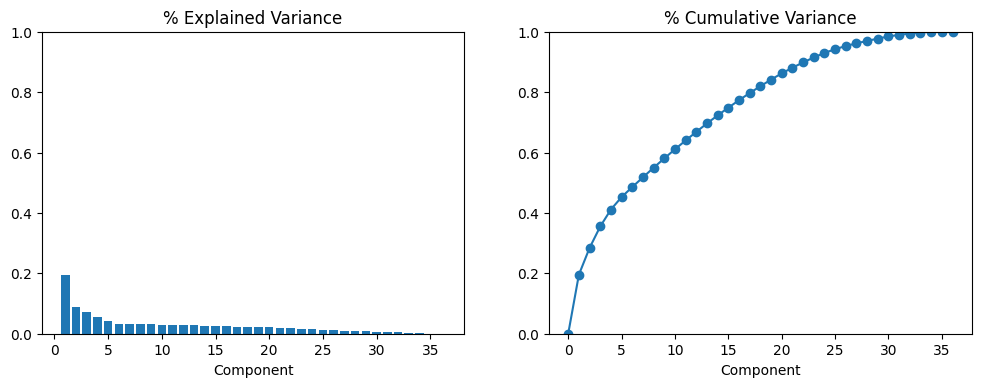

In [21]:
plot_variance(pca)
plt.show()

We can see in the graph that it is possible to keep only the first 25 features and save more than 90% of the variance.

In [22]:
X_cum = X_pca.drop(columns = X_pca.columns[25:])

### Feature selection using MI scores
Define a function to make MI scores.

In [23]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

Let's keep the first 25 features again.

In [24]:
mi_scores = make_mi_scores(X_pca, y, discrete_features = False)
X_mi = X_pca.drop(columns = mi_scores.index[25:])

mi_scores[:25]

PC0     1.015996
PC2     0.183813
PC1     0.123844
PC27    0.084708
PC3     0.082207
PC28    0.081871
PC15    0.068325
PC19    0.054707
PC4     0.050613
PC26    0.045514
PC13    0.045505
PC11    0.044309
PC25    0.042622
PC14    0.040609
PC6     0.038911
PC24    0.036319
PC10    0.035893
PC29    0.034275
PC17    0.031138
PC23    0.028960
PC32    0.024927
PC30    0.024227
PC7     0.018176
PC20    0.015701
PC5     0.014211
Name: MI Scores, dtype: float64

Drop **num_cols** because it is already stored in the **X** variable.

In [25]:
train_df = train_df.drop(columns = num_cols)
train_df

,MSZoning,LotShape,LandContour,LandSlope,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,ExterQual,...,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0.294505,-0.540826,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,-0.480095,1.063842,...,1,0,0,0,0,0,0,0,0,1
1,0.294505,-0.540826,-0.230289,-0.134105,-0.261603,-0.419552,-0.865037,0.161382,0.351928,-0.695466,...,1,0,0,0,0,0,0,0,0,1
2,0.294505,0.772894,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,-0.480095,1.063842,...,1,0,0,0,0,0,0,0,0,1
3,0.294505,0.772894,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,0.040602,-0.695466,...,1,0,0,0,0,0,0,0,0,1
4,0.294505,0.772894,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,-0.480095,1.063842,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.294505,-0.540826,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,-0.480095,-0.695466,...,1,0,0,0,0,0,0,0,0,1
1456,0.294505,-0.540826,-0.230289,-0.134105,-0.087651,-0.419552,-0.865037,0.161382,1.331219,-0.695466,...,1,0,0,0,0,0,0,0,0,1
1457,0.294505,-0.540826,-0.230289,-0.134105,-0.087651,-0.419552,1.332901,0.161382,-0.960738,2.753451,...,1,0,0,0,0,0,0,0,0,1
1458,0.294505,-0.540826,-0.230289,-0.134105,-0.087651,-0.419552,-0.865037,-0.797082,0.351928,-0.695466,...,1,0,0,0,0,0,0,0,0,1


# Prediction
I will test four data frames with different combinations of numerical features:
1. train_df + X
2. train_df + X_pca
3. train_df + X_cum
4. train_df + X_mi

Using 2 models:
- Random Forest
- Gradient Boosting

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

result = pd.DataFrame(columns = ['Random_Forest', 'Gradient_Boosting'], index = ['X', 'X_pca', 'X_cum', 'X_mi'])

df = [X, X_pca, X_cum, X_mi]
model = [RandomForestRegressor(random_state = 0), GradientBoostingRegressor(random_state = 0)]

Get scores.

In [27]:
for i, df_ in enumerate(df):
    data = pd.concat([train_df, df_], axis = 1)
    for j, model_ in enumerate(model):
        score = -1 * cross_val_score(model_, data, y, cv = 5, scoring = 'neg_mean_absolute_error')
        result.iloc[i, j] = score.mean()

Show results.

In [28]:
result

,Random_Forest,Gradient_Boosting
X,17611.274171,16016.334996
X_pca,17441.820733,15984.51943
X_cum,17583.559918,16111.977186
X_mi,17351.130575,16088.19711


# Feature impact analysis
I will show how each feature affects the price of houses using shap values.

In [29]:
from sklearn.model_selection import train_test_split
import shap

shap_df = pd.concat([train_df, X], axis = 1)
X_train, X_val, y_train, y_val = train_test_split(shap_df, y, train_size = 0.8, random_state = 0)
shap_model = GradientBoostingRegressor(random_state = 0).fit(X_train, y_train)

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_val)

The graph of features impact.

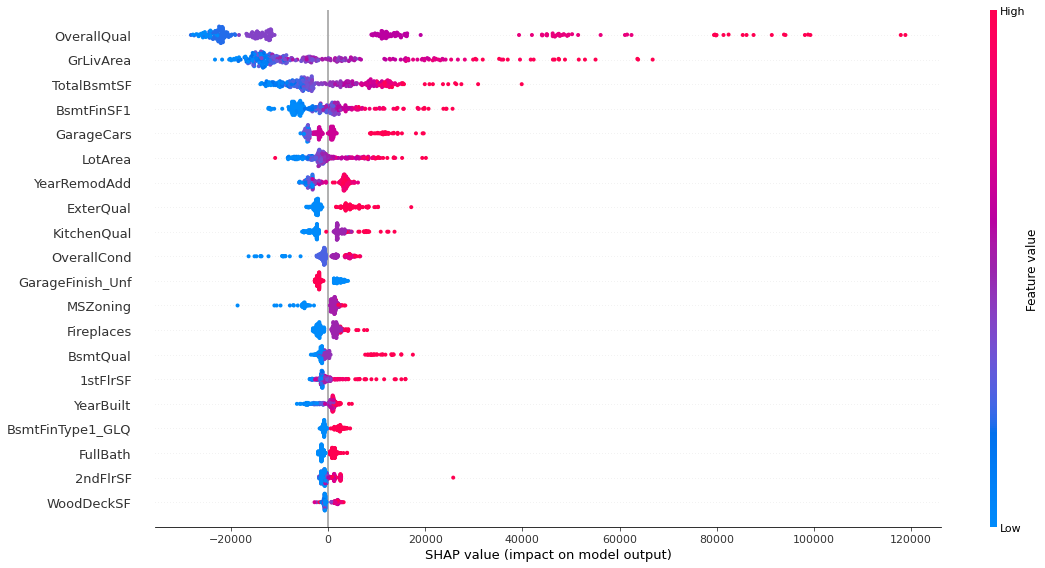

In [30]:
shap.summary_plot(shap_values, X_val, plot_size = (16, 8))